#Dependencies

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
from itertools import permutations
import codecs
import itertools
import time
from google.colab import output

#Classes used

In [35]:
class traveling_salesman:

  def __init__(self,n,bounds,costs=None):

    self.n = n
    self.bounds = bounds
    if costs is None:
      self.create_costs() 
    else:
      if len(costs[0]) is n and len(costs) is n:
        self.costs = costs
      else:
        raise Exception('Verify if the cost size is correct in relation to the route passed through the parameters.')
    self.time_used = None
  
  def create_costs(self):

    costs = []

    for i in range(self.n):
      row = []
      for j in range(self.n):
        row.append(round(random.uniform(self.bounds[0],self.bounds[1]),2))
      
      costs.append(row)
    
    self.costs =  costs

  def hill_climbing(self,route):

      [all_routes,all_costs,improved,iteration] = [[],[],True,0]

      old_route = route.copy() if route is not None else self.generate_one_random_solution()
      old_cost = self.calculate_cost(old_route)
      new_route = old_route

      all_routes.append(old_route)
      all_costs.append(old_cost)
      start_time = time.time()

      while(improved):
        
        [new_route,new_cost] = self.swap_2_first(old_route,False) 
        if new_cost < old_cost:

          old_route = new_route.copy()
          old_cost = new_cost

          iteration+=1
        
        else:
          improved = False
      
      end_time = time.time()
      self.time_used = end_time - start_time

      return [old_route,old_cost,iteration,self.time_used]

  def brute_force(self):

    current_cost = float('inf')
    current_route = []

    for route in itertools.permutations(range(self.n)):
      
      route = route + (route[0],)  # Route is a tuple.

      new_cost = self.calculate_cost(route)

      if new_cost < current_cost:

        current_cost = new_cost
        current_route = route

    return [current_route,current_cost]

  def generate_one_random_solution(self):

    solution = [vertex for vertex in range(self.n)]
    solution = random.sample(solution,self.n)
    solution.append(solution[0])

    return solution

  def greedy(self, initial_vertice = None):

    solution = [initial_vertice if initial_vertice is not None else randint(0,self.n-1)]
    [available_nodes,current_node,new_cost] = [[i for i in range(0,self.n)],solution[0],0]

    available_nodes.remove(current_node)
    
    start_time = time.time()

    for i in range(0,self.n-1):

      available_node_costs = [self.costs[current_node][j] for j in available_nodes]
      
      next_node = available_nodes[available_node_costs.index(min(available_node_costs))]
      #numpy argmin
      solution.append(next_node)
      new_cost += self.costs[current_node][next_node]

      available_nodes.remove(next_node)
      current_node = next_node

    solution.append(solution[0])
    new_cost+=self.costs[next_node][solution[0]]
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return solution,new_cost,None,self.time_used

  def calculate_cost(self,solution):
    
    sum = 0
    for i in range(1,len(solution)):

      sum += self.costs[solution[i-1]][solution[i]]
    
    return sum

  def swap_2_first(self,route = None,warning_condition=True):

    # Swap 2 vertices until finding a better solution. 
    solution = route.copy() if route is not None else self.generate_one_random_solution()

    current_cost = self.calculate_cost(solution)

    for i in range(self.n-2):

      for j in range(i+1,self.n-1):

        new_solution = solution.copy()
        
        aux = new_solution[j]
        new_solution[j] = new_solution[i] #swap
        new_solution[i] = aux

        new_solution[self.n] = new_solution[0]

        new_cost = self.calculate_cost(new_solution)
        
        if new_cost < current_cost:  
          solution = new_solution.copy()
          current_cost = new_cost
          return [solution,current_cost]
      
      if warning_condition: print('\n swap warning: Não foi encontrado nenhuma solução melhor, retornando o original\n')
      return [solution,current_cost]

  def vnd(self,route,e=0.01):
    
    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    counter = 0
    improvement = True
    all_cost = [old_cost]

    start_time = time.time()

    while(improvement):
      
      counter += 1
      [current_route,current_cost] = self.swap_2_first(old_route,False)

      if current_cost + e < old_cost:
         old_cost = current_cost
         old_route = current_route.copy()
         
         all_cost.append(old_cost)
         continue
      else:
        improvement = False

      [current_route,current_cost] = self.opt_2(old_route)

      if current_cost + e < old_cost:
        old_cost = current_cost
        old_route = current_route.copy()
        improvement = True

        all_cost.append(old_cost)

    end_time = time.time()
    self.time_used = end_time - start_time
    
    return [old_route,round(old_cost,3),counter,self.time_used]

  
  def opt_2(self,route):

    new_route = route.copy()
    node_number = len(route)
    new_costs = self.calculate_cost(route)
    costs =  self.costs

    for i in range(node_number-2):

      for j in range(i+2,node_number-1):

        if costs[route[i]][route[i+1]] + costs[route[j]][route[j+1]] > costs[route[i]][route[j]]+costs[route[i+1]][route[j+1]]:

          aux = route[j]
          route[j] = route[i+1]
          route[i+1] = aux

          new_costs = self.calculate_cost(route)
        
    return [route,new_costs]


  def opt_2_first(self,route,warning_condition=False):

      new_route = route.copy()
      node_number = len(route)
      new_costs = self.calculate_cost(route)
      costs =  self.costs

      for i in range(node_number-3):

        for j in range(i+2,node_number-1):

          if costs[route[i]][route[i+1]] + costs[route[j]][route[j+1]] > costs[route[i]][route[j]]+costs[route[i+1]][route[j+1]]:

            aux = route[j]
            route[j] = route[i+1]
            route[i+1] = aux

            new_costs = self.calculate_cost(route)

            return [route,new_costs]
      
      if warning_condition: print('Warning: Nenhum melhoramento encontrado')
          
      return [route,new_costs]

  def random_mult_start(self,route,max_iteration,e=0.01):
    
    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    count = 0

    start_time = time.time()

    for i in range(max_iteration):

      greedy_random_route = self.generate_one_random_solution()
      [new_route,new_cost,useless_variable,useless_variable_2] = self.vnd(greedy_random_route,e)
      count+=1
      if new_cost < old_cost:

        old_route = new_route.copy()
        old_cost = new_cost
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return old_route,old_cost,max_iteration,self.time_used


  def iterated_local_search(self,max_iteration): # I need to add the disturbance before the VND.

    [old_solution,old_cost,useless] = self.random_mult_start(1)
    [improvement,count] = [True,0]
    
    start_time = time.time()

    while improvement and count<max_iteration:
      
      vnd_results = self.vnd(old_solution,0.01,max_iteration)
      [current_solution,current_cost] = [vnd_results[0],vnd_results[1]]

      if current_cost < old_cost:
        
        old_solution = current_solution.copy()
        old_cost = current_cost
      else:
        improvement = False

      count+=1
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return [old_solution,old_cost,count]

  def GRASP(self,route,k,max_iteration,e=0.01):

    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    count = 0
    
    start_time = time.time()

    for i in range(max_iteration):

      greedy_random_route = self.greedy_random(k)
      [new_route,new_cost,useless_variable,useless_variable_2] = self.vnd(greedy_random_route)
      count+=1
      if new_cost < old_cost:

        old_route = new_route.copy()
        old_cost = new_cost
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return old_route,old_cost,max_iteration,self.time_used

  def greedy_random(self,k,initial_vertice=None):

      solution = [initial_vertice if initial_vertice is not None else randint(0,self.n-1)]
      [available_nodes,current_node,new_cost] = [[i for i in range(0,self.n)],solution[0],0]

      available_nodes.remove(current_node)
      
      for i in range(0,self.n-1):

        available_node_costs = [self.costs[current_node][j] for j in available_nodes]
        
        sorted_available_node_costs = available_node_costs.copy()
        sorted_available_node_costs.sort()

        if len(sorted_available_node_costs) >= k:
          k_best_available_nodes_costs = [sorted_available_node_costs[best_cost] for best_cost in range(k)]
          # Drawing the elements from best_available_k_node_costs array based on the costs.
          inv_k_best_available_nodes_costs = [1/inv for inv in k_best_available_nodes_costs]  
          drawn_cost = random.choices(k_best_available_nodes_costs,weights=inv_k_best_available_nodes_costs,k=1)[0]
        else:
          drawn_cost = random.choices(sorted_available_node_costs,weights=sorted_available_node_costs,k=1)[0]
        
        next_node = available_nodes[available_node_costs.index(drawn_cost)]
        solution.append(next_node)
        available_nodes.remove(next_node)
        current_node = next_node

      solution.append(solution[0])

      return solution

class performing_simulations:

  def __init__(self,models,node_number,parameters,max_iteration,initial_routes=None):

    self.models = models
    self.model_names = [model.__name__ for model in models]
    self.routes = initial_routes
    self.node_number = node_number
    self.max_iteration = max_iteration
    self.parameters = parameters
  
  def execute(self):

    results = dict()

    for name in self.model_names:
      
      results[name] = dict(parameter = [],k = [],cost = [],time_used = [],iterations = [])
      
    for index,model_name in enumerate(self.model_names):

      for iteration in range(self.max_iteration):
          #print(self.parameters)
        for parameter in self.parameters[model_name]:

          if 'greedy' == model_name:
            result_per_parameter = self.models[index](*parameter)
          else:
            result_per_parameter = self.models[index](self.routes[iteration],*parameter)

          results[model_name]['k'].append(self.node_number)
          results[model_name]['cost'].append(result_per_parameter[1])
          results[model_name]['parameter'].append(parameter)
          results[model_name]['time_used'].append(result_per_parameter[3])
          results[model_name]['iterations'].append(result_per_parameter[2])


    return results



#Functions used

In [11]:
def generate_distances(node_number):

  xs = [randint(0,10*node_number) for x in range(node_number)]
  ys = [randint(0,10*node_number) for x in range(node_number)]

  xs.append(xs[0])
  ys.append(ys[0])

  calculate_distance = lambda x_dif,y_dif: (x_dif**2+y_dif**2)**(1/2)

  distances = []

  for i in range(node_number):
      row = []
      for j in range(node_number):
        if i is not j:
          row.append(round(calculate_distance(xs[i]-xs[j],ys[i]-ys[j]),4))
        else:
          row.append(float('inf'))
      
      distances.append(row)

  return distances,xs,ys

def create_loading_bar(current,total):
    output.clear()
    bar = ''
    percent = (current/total)*100
    percent_bar = round(percent/10)
    for i in range(percent_bar):
      bar+='*'
    for i in range(percent_bar+1,11):
      bar+='-'
    print(f'[{bar}] {round(percent,2)}')

def plot_vertices(route,xs,ys,node_number,line_cor = 'black',cost_text=None,cost_matrix=None,save_fig=False,name_fig='chooseMyName',title_pic=None):

  plt.figure(figsize=(10,6))
  ys = [ys[i] for i in route]
  xs = [xs[i] for i in route]
  plt.plot(xs,ys,line_cor)
  plt.plot(xs,ys,'ob')
  plt.title(title_pic)
  
  for i in range(node_number):
  
    plt.text(xs[i]-0.2,ys[i]+0.2,'Node '+str(route[i]))
  
  if cost_text is not None:
  
    for i in range(node_number):
      plt.text(cost_text[i][0],cost_text[i][1],str(cost_matrix[cost_text[i][2]][cost_text[i][3]]))
  
  if save_fig:
    plt.savefig(name_fig)
  plt.show()

def convex_combination_of_edges(route,xs,ys,alpha,node_number):

  if alpha>1 or alpha < 0: raise Exception('alpha inválido')

  edges = []
  #ys = [ys[i] for i in xs]
  for i in range(node_number):
    edges.append([alpha*xs[route[i]]+(1-alpha)*xs[route[i+1]],alpha*ys[route[i]]+(1-alpha)*ys[route[i+1]],route[i],route[i+1]])

  return edges

#Generating a random route and calculating the distance among all dots.

In [149]:
node_number = 50
distances,xs,ys = generate_distances(node_number)

## Showing all costs and setting up the parameters.

A rota aleatoria gerada foi [0, 22, 7, 43, 1, 39, 32, 6, 21, 49, 3, 25, 11, 35, 9, 30, 10, 16, 17, 24, 38, 47, 44, 15, 18, 37, 23, 33, 46, 27, 8, 5, 26, 48, 14, 29, 20, 12, 31, 41, 4, 45, 19, 2, 28, 13, 40, 42, 34, 36, 0] e o seu custo é 12359.568499999994


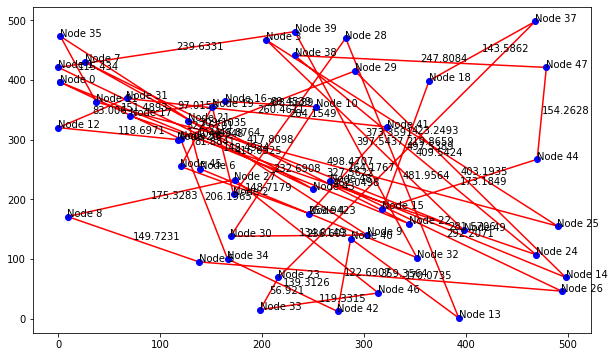

In [150]:
simulation = traveling_salesman(node_number,[10,300],distances)
initial_route = simulation.generate_one_random_solution()
#display(pd.DataFrame(simulation.costs))
print(f'A rota aleatoria gerada foi {initial_route} e o seu custo é {simulation.calculate_cost(initial_route)}')
time_random = None
cost_texts = convex_combination_of_edges(initial_route,xs,ys,0.5,node_number)
plot_vertices(initial_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)



#heuristics

In [151]:
result_costs = [] # Append the costs of the generated routes by the algorithms to this array.
result_costs.append(simulation.calculate_cost(initial_route))
times = []
times.append(None)

##Greedy

A rota gerada pela seleção do melhor caminho foi [0, 1, 7, 35, 11, 31, 17, 21, 36, 20, 45, 6, 27, 2, 30, 34, 5, 23, 33, 42, 46, 32, 22, 15, 9, 40, 4, 43, 48, 41, 10, 29, 28, 39, 3, 38, 16, 19, 12, 8, 49, 24, 14, 26, 25, 44, 47, 37, 18, 13, 0] e o seu custo é 4199.72 e tbm deve ser 4199.717200000001


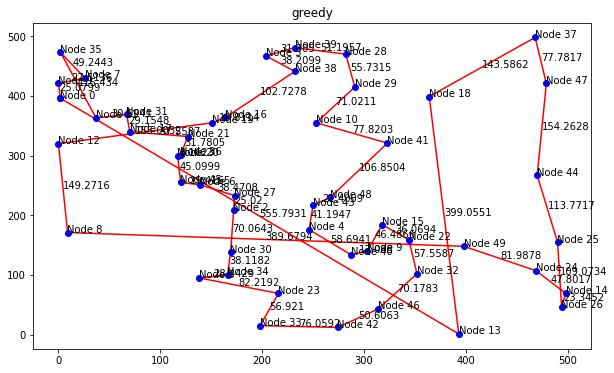

In [152]:
route_greedy,cost,count,time_used = simulation.greedy()
simulation.calculate_cost(route_greedy)

print(f'A rota gerada pela seleção do melhor caminho foi {route_greedy} e o seu custo é {round(simulation.calculate_cost(route_greedy),2)} e tbm deve ser {cost}')

cost_texts = convex_combination_of_edges(route_greedy,xs,ys,0.5,node_number)

plot_vertices(route_greedy,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig='greedy',title_pic='greedy')

times.append(simulation.time_used)
result_costs.append(cost)


## Hill Climbing

A melhor rota por Hill Climbing com swap e 2 opt foi [19, 3, 11, 35, 2, 25, 43, 22, 32, 49, 6, 7, 1, 0, 9, 30, 20, 21, 10, 24, 38, 47, 44, 15, 18, 37, 23, 33, 46, 27, 8, 5, 26, 48, 14, 29, 17, 12, 31, 41, 4, 45, 16, 39, 28, 13, 40, 42, 34, 36, 19] e o seu custo é 9656.17 e tbm deve ser 9656.1675
Quantidade de iterações necessárias 33


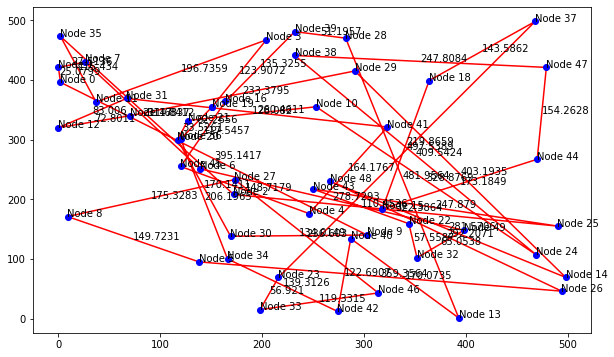

In [153]:

[hill_route,hill_cost,iterations,time_used] = simulation.hill_climbing(initial_route)

print(f'A melhor rota por Hill Climbing com swap e 2 opt foi {hill_route} e o seu custo é {round(simulation.calculate_cost(hill_route),2)} e tbm deve ser {hill_cost}')
print(f'Quantidade de iterações necessárias {iterations}')
cost_texts = convex_combination_of_edges(hill_route,xs,ys,0.5,node_number)

plot_vertices(hill_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)

times.append(simulation.time_used)
result_costs.append(hill_cost)

##VND

[28, 38, 39, 3, 16, 19, 21, 17, 31, 7, 35, 1, 0, 11, 12, 8, 5, 30, 34, 23, 33, 42, 46, 13, 26, 14, 24, 25, 44, 47, 37, 18, 41, 49, 32, 40, 9, 22, 15, 4, 48, 43, 2, 27, 6, 45, 20, 36, 10, 29, 28] 3269.877 40 3269.8767


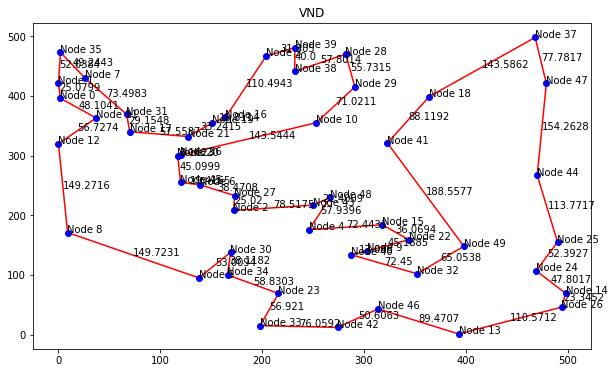

In [154]:
[vnd_route,vnd_cost,iterations,time_used] = simulation.vnd(initial_route,0.01)

print(vnd_route,vnd_cost,iterations,simulation.calculate_cost(vnd_route))

cost_texts = convex_combination_of_edges(vnd_route,xs,ys,0.5,node_number)

plot_vertices(vnd_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig="VND",title_pic="VND")

times.append(simulation.time_used)
result_costs.append(vnd_cost)

##Random multi Start

A melhor solução gerada pelo RMS foi [16, 17, 31, 11, 7, 35, 1, 0, 12, 8, 5, 30, 34, 23, 33, 42, 46, 13, 26, 14, 24, 25, 44, 47, 37, 18, 29, 28, 39, 3, 38, 10, 41, 15, 22, 49, 32, 9, 40, 4, 48, 43, 2, 27, 6, 45, 20, 36, 21, 19, 16] e o seu custo é de 3091.07 


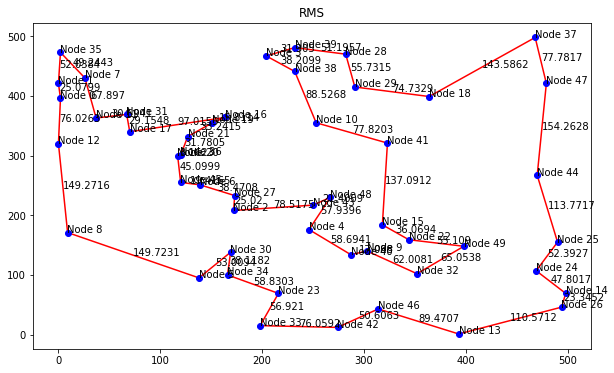

In [155]:
route_rms, cost, count, time_used = simulation.random_mult_start(initial_route,100,0.01)

print(f'A melhor solução gerada pelo RMS foi {route_rms} e o seu custo é de {round(cost,2)} ')

cost_texts = convex_combination_of_edges(route_rms,xs,ys,0.5,node_number)

plot_vertices(route_rms,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig="RMS",title_pic='RMS')

times.append(simulation.time_used)
result_costs.append(cost)


##GRASP

A rota pelo Grasp foi [13, 46, 42, 33, 23, 34, 5, 30, 2, 27, 6, 45, 8, 12, 0, 1, 35, 7, 11, 31, 17, 20, 36, 21, 19, 16, 38, 3, 39, 28, 29, 10, 41, 18, 37, 47, 44, 49, 22, 15, 48, 43, 4, 40, 9, 32, 25, 24, 14, 26, 13] e o seu custo é 3103.56 e tbm deve ser 3103.562


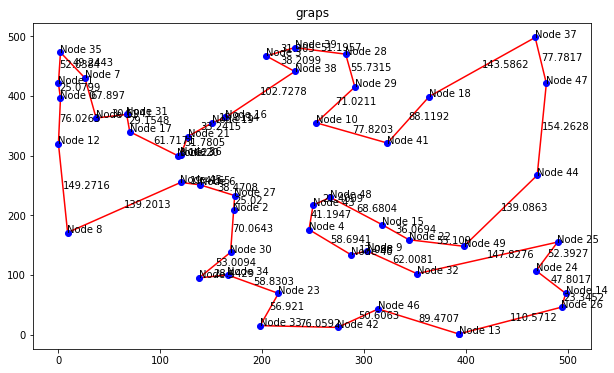

In [156]:
[grasp_route,grasp_cost,count,time_used] = simulation.GRASP(initial_route,3,100)

print(f'A rota pelo Grasp foi {grasp_route} e o seu custo é {round(simulation.calculate_cost(grasp_route),2)} e tbm deve ser {grasp_cost}')

cost_texts = convex_combination_of_edges(grasp_route,xs,ys,0.5,node_number)

plot_vertices(grasp_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig="grasp",title_pic='graps')

times.append(simulation.time_used)
result_costs.append(grasp_cost)


# Comparison of Results

In [158]:
df_result_costs = pd.DataFrame([result_costs,times],index=['Custo da rota','Tempo usado(seg.)'],columns=['Aleatória','Greedy','Hill Climbing','VND','Random Multi Start','Grasp']).T
display(df_result_costs)

,Custo da rota,Tempo usado(seg.)
Aleatória,12359.5685,NaN
Greedy,4199.7172,0.000438
Hill Climbing,9656.1675,0.008205
VND,3269.8770,0.023133
Random Multi Start,3091.0700,2.843807
Grasp,3103.5620,0.921863


In [ ]:
parameters = {
    'greedy':[[None]],
    'vnd':[[]],
    'hill_climbing':[[]],
    'random_mult_start':[[1],[10],[100],[1000]],
    'GRASP':[[2,10],[2,100],[3,10],[3,100],[4,10],[4,100]]
}

parameter_names = {
    'greedy':['initial_node'],
    'vnd':[None],
    'hill_climbing':[None],
    'random_mult_start':['max_iteration'],
    'GRASP':['roulette','max_iteration']
}

range_node = (60,65)
result_dic = dict()
simulations_per_k = 3
total = range_node[1]-range_node[0]

for k in range(range_node[0],range_node[1]):
  create_loading_bar(k-range_node[0]+1,total)
  distances = generate_distances(k)
  model = traveling_salesman(k,[10,300],distances[0])
  initial_routes = [model.generate_one_random_solution() for nothing in range(simulations_per_k)]
  models = [model.greedy,model.vnd,model.hill_climbing,model.random_mult_start,model.GRASP]

  result_dic[str(k)] = performing_simulations(models,k,parameters,simulations_per_k,initial_routes).execute()


In [160]:
def split_parameter_table(result_dic,range_node,parameter_names):

  method_names =  parameter_names.keys()

  for node in range(range_node[0],range_node[1]):

    for method_name in method_names:
      
      if method_name == 'vnd' or method_name == 'hill_climbing' or 'random_mult_start' == method_name:
        continue
      else:
        df_method = pd.DataFrame(result_dic[str(node)][method_name])
        split = pd.DataFrame(df_method['parameter'].to_list(),columns=parameter_names[method_name])
        #display(split)
        result_dic[str(node)][method_name] = pd.concat([split,df_method],axis=1)

  return result_dic

result_dic = split_parameter_table(result_dic,range_node,parameter_names)

In [163]:
display(pd.DataFrame(result_dic['61']['GRASP']))

,roulette,max_iteration,parameter,k,cost,time_used,iterations
0,2,10,"[2, 10]",61,3809.620,0.136733,10
1,2,100,"[2, 100]",61,3641.779,1.108896,100
2,3,10,"[3, 10]",61,3693.782,0.139874,10
3,3,100,"[3, 100]",61,3633.232,1.472664,100
4,4,10,"[4, 10]",61,3717.164,0.144845,10
5,4,100,"[4, 100]",61,3633.850,1.681375,100
6,2,10,"[2, 10]",61,3961.563,0.097267,10
7,2,100,"[2, 100]",61,3575.356,1.081194,100
8,3,10,"[3, 10]",61,3759.434,0.140236,10
9,3,100,"[3, 100]",61,3575.356,1.431405,100


#brute force


A melhor rota por Força bruta foi (0, 1, 4, 3, 2, 0) e o seu custo é 103.184 e tbm deve ser 103.1842


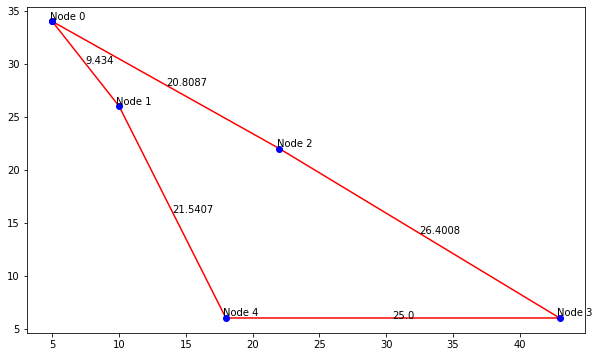

In [ ]:
[best_route,best_cost] = simulation.brute_force()

print(f'A melhor rota por Força bruta foi {best_route} e o seu custo é {round(simulation.calculate_cost(best_route),3)} e tbm deve ser {best_cost}')

cost_texts = convex_combination_of_edges(best_route,xs,ys,0.5,node_number)

plot_vertices(best_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig='Brute_force')
